<a href="https://colab.research.google.com/github/RealMyeong/Going_Deeper_NLP/blob/main/Hugginface_%EC%BB%A4%EC%8A%A4%ED%85%80_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- mrpc 데이터셋 분석


In [1]:
# !pip install transformers
# !pip install datasets
# !pip install evaluate

In [2]:
import os
import numpy as np
from argparse import ArgumentParser
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

print("슝~")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

슝~


In [3]:
data, info = tfds.load('glue/mrpc', with_info=True)
info.splits['train'].num_examples

3668

In [4]:
data['train'].take(1)

<TakeDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [5]:
examples = data['train'].take(1)
for example in examples:
    sentence1 = example['sentence1']
    sentence2 = example['sentence2']
    label = example['label']
    print(sentence1)
    print(sentence2)
    print(label)

tf.Tensor(b'The identical rovers will act as robotic geologists , searching for evidence of past water .', shape=(), dtype=string)
tf.Tensor(b'The rovers act as robotic geologists , moving on six wheels .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


- Processor의 활용

아래는 추상클래스인 Processor를 한번 상속받은 후, Sequence Classification task를 수행하는 모델의 Processor 추상클래스인 DataProcessor입니다.

In [6]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

print("슝~")

슝~


아직은 추상클래스 상태이기 때문에 그대로 사용하면 NotImplementedError를 발생시키는 메소드들이 포함되어 있습니다. 이 메소드들을 오버라이드해야 실제 사용 가능한 클래스가 얻어지겠죠?

아래는 'mrpc' 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 MrpcProcessor 클래스입니다.

In [7]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence1"].numpy().decode("utf-8"),
            tensor_dict["sentence2"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

print("슝~")

슝~


이것만으로는 클래스 구조와 메커니즘이 눈에 잘 안 들어오죠? 여기서 우선 주목해야 할 메소드는 get_example_from_tensor_dict()입니다. 실제로 이 메소드가 어떤 역할을 하게 되는지 살펴봅시다.

In [8]:
processor = MrpcProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>, 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}
------processor 가공데이터------
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


원본과 비교해보니 Processor가 하는 역할이 무엇인지 좀 더 명확해지시나요? 한마디로 요약하자면 Processor는 'Raw Dataset를 Annotated Dataset으로 변환'하는 역할을 합니다. 항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환되어 있음을 알 수 있습니다.

다음 코드는 tfds_map() 메소드를 활용한 경우입니다.

In [9]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print(example)

InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


이전과 별다른 차이는 없습니다. tfds_map는 label을 가공하는 메소드인데, 이미 숫자로 잘 가공된 label이기 때문에 특별한 변화가 없습니다.

실제 label을 확인하여 Binary Classification 문제로 잘 정의되고 있는지 확인해 봅시다.

In [10]:
label_list = processor.get_labels()
label_list

['0', '1']

In [11]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1}

- huggingface datasets을 이용하는 방법

지금까지 우리는 tensorflow datasets을 이용해서 데이터를 확인했습니다. 이 방법보다 쉽고 간편한 방법이 있습니다. 바로 Huggingface에서 제공하는 datasets를 이용하는 방법입니다.

Huggingface datasets을 이용하는 방법은 다음과 같습니다.

In [12]:
import datasets
from datasets import load_dataset

huggingface_mrpc_dataset = load_dataset('glue', 'mrpc')
print(huggingface_mrpc_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


huggingface mrpc dataset을 확인해보면 위와 같이 구성되어 있습니다.

Dataset dictionary안에 train dataset, validation dataset, test dataset으로 구성되어 있고 각 Dataset은 ‘sentence1’, ‘sentence2’, ‘label’, ‘idx’(인덱스)로 구성되어 있습니다. 해당 내용처럼 Huggingface datasets를 사용하면 DataProcessor를 사용할 필요없이 바로 사용가능하게 구성되어 있습니다.

Processor를 통해 Framework을 활용하여 데이터셋을 가공하는 작업을 잘 진행했다면 이미 절반 이상 진행한 것이나 마찬가지입니다. NLP 모델링의 핵심을 이루는 Tokenizer와 Model은 framework에서 이미 잘 만들어져 있는 것을 쉽게 가져다 쓸 수 있기 때문입니다.

그럼 이전 스텝에서 만든 MRPCProcessor 클래스와 framework를 결합시켜 나가는 과정을 진행해 보겠습니다. 우선 아래와 같이 tokenizer와 model을 간단히 생성합니다.

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

이제 processor와 tokenizer, 원본 데이터셋을 결합하여 model에 입력할 데이터셋을 생성해 보겠습니다.



In [14]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

print("슝~")

슝~


In [15]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

print("슝~")

슝~


`_glue_convert_examples_to_features()` 함수는 processor가 생성한 example을 `tokenizer로` 인코딩하여 feature로 변환하는 역할을 합니다. 

이후 `tf_glue_convert_examples_to_features()` 함수는 내부적으로 `_glue_convert_examples_to_features()`를 호출해서 얻은 feature를 바탕으로 `tf.data.Dataset`을 생성하여 리턴합니다.

In [16]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1']
*** Example ***
guid: 1680
features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, 1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, lab

tf_glue_convert_examples_to_features() 함수가 최종적으로 모델에 전달될 tf.data.Dataset 인스턴스를 생성합니다. 위 코드는 그렇게 생성된 학습 단계 데이터셋 train_dataset입니다.



In [17]:
examples = train_dataset.take(1)
for example in examples:
    print(example)

({'input_ids': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,
        2015,  1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,
         102,  1996,  9819,  2552,  2004, 20478, 21334,  2015,  1010,
        3048,  2006,  2416,  7787,  1012,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

In [18]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1']
*** Example ***
guid: 1680
features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, 1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, lab

In [19]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1']
*** Example ***
guid: 3155
features: InputFeatures(input_ids=[101, 1996, 2265, 1005, 1055, 8503, 5360, 2353, 1011, 4284, 16565, 2566, 3745, 2011, 1037, 10647, 1012, 102, 1996, 2194, 2056, 2023, 19209, 16565, 2011, 1037, 10647, 1037, 3745, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=1)

In [20]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1']
*** Example ***
guid: 163
features: InputFeatures(input_ids=[101, 6661, 1999, 8670, 2020, 2091, 1015, 1012, 1019, 3867, 2012, 16923, 7279, 3401, 2011, 16087, 2692, 13938, 2102, 1010, 2125, 1037, 2659, 1997, 17943, 2361, 1010, 1999, 1037, 3621, 6428, 3452, 2414, 3006, 1012, 102, 6661, 1999, 8670, 2020, 2091, 2093, 3867, 2012, 13913, 1011, 1015, 1013, 1018, 7279, 3401, 2011, 5641, 22394, 13938, 2102, 1010, 2125, 1037, 2659, 1997, 17943, 7279, 3401, 1010, 1999, 1037, 6428, 3006, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Huggingface의 경우 AutoTokenizer, AutoModel기능을 지원합니다.

AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class입니다.

Auto class는 from_pretrained 메소드를 이용해 pretrained model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법입니다.

즉 bert를 사용할때 BertTokenizer, RoBERTa를 사용할때 RobertaTokenizer를 사용하게 되는데 AutoTokenizer를 이용하면 자동으로 BERT모델은 BERT로 RoBERTa모델은 RoBERTa로 바꿔줍니다.

model도 마찬가지입니다. 다만 model의 경우 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식인 AutoModelForSequenceClassification을 사용하는걸 권장드립니다.

Auto class는 다양한 모델에 자동으로 맞출 수 있기 떄문에 특정 task와 dataset이 주어져있는 경우 모델을 다양하게 넣어 실험할 수 있습니다.

그렇기에 Auto class를 유용하게 활용하는 것을 추천합니다.

Tokenizer와 Model을 만들었다면 이제 토크나이징하는 방법을 알아보도록 하겠습니다.

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데 이때 dataset의 형태를 확인하고 바꿀 대상을 지정해야 합니다.

mrpc의 경우 sentence1, sentence2가 토크나이징할 대상이므로 data[’sentence1’], data[’sentence2’]로 인덱싱해서 지정합니다.

truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미합니다.

return_token_type_ids는 문장이 한개이상일 때 나뉘는걸 보여줍니다. (해당 내용은 task에 필요없으므로 제거합니다)

예시까지 확인하면 다음과 같이 확인할 수 있습니다.

In [22]:
def transform(data):
  return huggingface_tokenizer(
      data['sentence1'],
      data['sentence2'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = False,
      )
  
examples = huggingface_mrpc_dataset['train'][:5]
examples_transformed = transform(examples)

print(examples)
print(examples_transformed)

{'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .', 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .'], 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .", "On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .", 'Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .', 'P

데이터셋을 한번에 토크나이징할때 자주 사용하는 기법은 map입니다.

map을 사용하게 되면 Data dictionary에 있는 모든 데이터들이 빠르게 적용시킬 수 있습니다.

우리는 map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 주어야 합니다.

In [23]:
encoded_dataset = huggingface_mrpc_dataset.map(transform, batched=True)

- tf.keras.model 을 활용한 학습

우선, 우리에게 익숙한 model.fit()을 이용한 모델학습을 진행해 봅시다.

In [24]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print("슝~")

슝~


In [25]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


학습을 진행해 봅시다. 이 학습은 이미 잘 훈련된 BERT 모델을 가져다가 fine-tuning하는 작업임을 기억합시다.

편의상 3 Epoch만 진행한 후의 성능을 체크해 봅시다.

In [26]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=3, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/3
115/115 [==============================] - 39s 252ms/step - loss: 0.5722 - acc: 0.6962 - val_loss: 0.4851 - val_acc: 0.7770
Epoch 2/3
115/115 [==============================] - 27s 238ms/step - loss: 0.4750 - acc: 0.7626 - val_loss: 0.4391 - val_acc: 0.8235
Epoch 3/3
115/115 [==============================] - 27s 236ms/step - loss: 0.3503 - acc: 0.8533 - val_loss: 0.4455 - val_acc: 0.8505


In [27]:
result = model.evaluate(test_dataset_batch)
print(result)

108/108 [==============================] - 9s 80ms/step - loss: 0.4421 - acc: 0.7577
[0.4421393871307373, 0.757681131362915]


In [28]:
import os
output_dir = '/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face'
output_eval_file = os.path.join(output_dir, "eval_results.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))
print("완료=3")

#파일에 쓴 테스트 결과 확인
!cat /content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face/eval_results.txt

완료=3
Loss = 0.442139	Accuracy = 0.757681


- Trainer를 활용한 학습

이번에는 Huggingface에서 Trainer을 활용해 학습을 진행해보도록 하겠습니다.

Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정해야 합니다.

In [29]:
#메모리를 비워줍니다.
del model
del train_dataset_batch
del validation_dataset_batch
del test_dataset_batch

In [30]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments
output_dir = '/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
)

아래에서 생성하게 될 Trainer의 인자로 넘겨주어야 할 것 중에 compute_metrics 메소드가 있습니다. 이것은 task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로 task별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정해 두는 것입니다.



In [31]:
# from datasets import load_metric
import evaluate
# metric = load_metric('glue', 'mrpc')
metric = evaluate.load('glue', 'mrpc')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [32]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()
print("슝~")

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2. If idx, sentence1, sentence2 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 690


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.390765,0.813725,0.872054
2,No log,0.360409,0.845588,0.893761
3,0.438200,0.395458,0.850490,0.896435


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2. If idx, sentence1, sentence2 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2. If idx, sentence1, sentence2 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face/checkpoint-500
Configuration saved in /content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face/checkpoint-500/config.json
Model weights saved 

슝~


In [33]:
trainer.evaluate(encoded_dataset['test'])


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence1, sentence2. If idx, sentence1, sentence2 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1725
  Batch size = 16


{'eval_loss': 0.4354531466960907,
 'eval_accuracy': 0.8272463768115942,
 'eval_f1': 0.8746846089150547,
 'eval_runtime': 31.976,
 'eval_samples_per_second': 53.947,
 'eval_steps_per_second': 3.378,
 'epoch': 3.0}

## 커스텀 프로젝트 직접 만들기

실습 코드에서 수행해 본 내용을 토대로, 이번에는 GLUE dataset의 mnli task를 수행하는 프로젝트를 커스텀 프로젝트 형태로 진행해 봅시다.

mnli task는 이전 스텝에서 사용한 BERT를 사용하면 학습이 제대로 되지 않습니다. 여기를 참조하여 BERT가 아닌 다른 모델을 선택하세요. tensorflow와 해당 모델에 대한 task로 검색하면 사용할 수 있는 모델이 나옵니다. 그 후 선택한 모델의 _tokenizer_와 해당 모델에 대한 task 와 모델 의 정보를 여기에서 찾아 여러분의 프로젝트를 완성해 보세요.

그냥 run_glue.py를 돌려보는 방식으로 진행하는 것을 원하는 것은 아닙니다. 아래와 같은 순서를 지켜서 진행해 주세요.

STEP 1. mnli 데이터셋을 분석해 보기

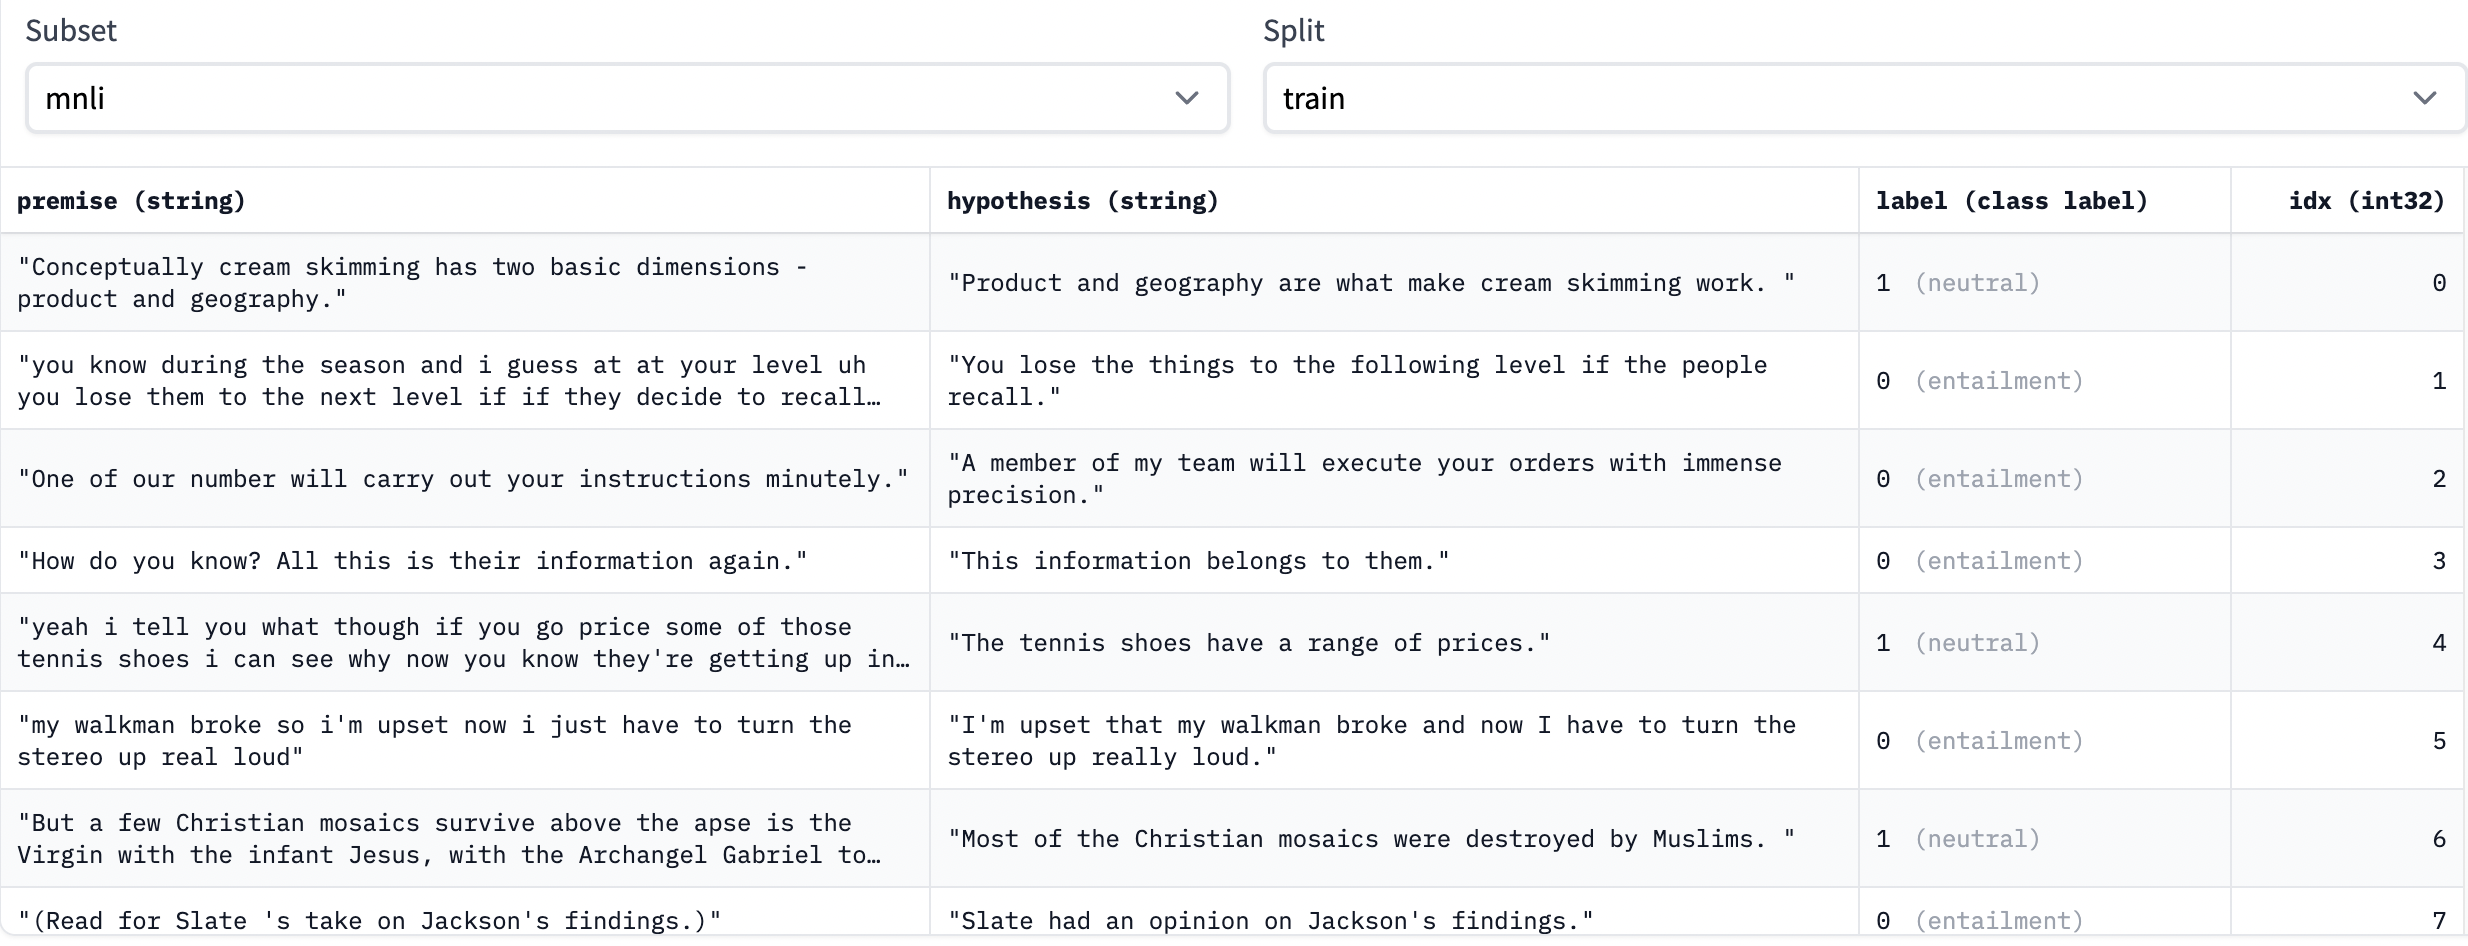

task는 전제(premise)가 가설(hypothesis)을 수반하는지(entailment), 모순 되는지(contradiction), 둘 다가 아닌지(nuetral) 예측하는 task.

In [34]:
import os
import numpy as np
from argparse import ArgumentParser
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

In [35]:
data, info = tfds.load('glue/mnli', with_info=True)
info.splits['train'].num_examples

392702

In [36]:
data['train'].take(1)

<TakeDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [37]:
examples = data['train'].take(1)
for example in examples:
    hypothesis = example['hypothesis']
    premise = example['premise']
    label = example['label']
    print(hypothesis)
    print(premise)
    print(label)

tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)
tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [38]:
# huggingface_mnli_dataset = load_dataset('glue', 'mnli')
# print(huggingface_mnli_dataset)

STEP 2. MNLIProcessor클래스 구현하기


In [39]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

print("슝~")

슝~


In [40]:
class MnliProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["premise"].numpy().decode("utf-8"),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

print("슝~")

슝~


In [41]:
processor = MnliProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeh

In [42]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print(example)

InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeholders is crucial.', label='1')


In [43]:
label_list = processor.get_labels()
label_list

['0', '1', '2']

In [44]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1, '2': 2}

STEP 3. 위에서 구현한 processor 및 Huggingface에서 제공하는 tokenizer를 활용하여 데이터셋 구성하기


In [45]:
# !pip install sentencepiece

In [46]:
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [47]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = TFXLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)


Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.23.1",
  "untie_r":

Downloading:   0%|          | 0.00/565M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/tf_model.h5
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRA

In [48]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

print("슝~")

슝~


In [49]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

print("슝~")

슝~


In [50]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=256, processor=processor)

Using label list ['0', '1', '2']
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [51]:
examples = train_dataset.take(1)
for example in examples:
    print(example)

({'input_ids': <tf.Tensor: shape=(512,), dtype=int32, numpy=
array([    5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,     5,     5,     5,     5,     5,     5,
           5,     5,     5,  

- 전체 데이터셋 구성


In [52]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=256, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1', '2']
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [53]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'], tokenizer, max_length=256, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']
*** Example ***
guid: 6287
features: InputFeatures(input_ids=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [54]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'], tokenizer, max_length=256, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']
*** Example ***
guid: 5398
features: InputFeatures(input_ids=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

STEP 4. model을 생성하여 학습 및 테스트를 진행해 보기


In [55]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print("슝~")

슝~


In [56]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLay  multiple                 116718336 
 er)                                                             
                                                                 
 sequence_summary (TFSequenc  multiple                 590592    
 eSummary)                                                       
                                                                 
 logits_proj (Dense)         multiple                  2307      
                                                                 
Total params: 117,311,235
Trainable params: 117,311,235
Non-trainable params: 0
_________________________________________________________________


In [57]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=3, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/3


ResourceExhaustedError: ignored

In [ ]:
result = model.evaluate(test_dataset_batch)
print(result)

In [ ]:
# # Trainer을 활용하는 형태로 모델 재생성
# from transformers import Trainer, TrainingArguments
# output_dir = '/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/16_hugging_face'
# metric_name = 'accuracy'

# training_arguments = TrainingArguments(
#     output_dir, # output이 저장될 경로
#     adam_beta1=0.9,
#     adam_beta2=0.98,
#     adam_epsilon=1e-6,                                      
#     evaluation_strategy="epoch", #evaluation하는 빈도
#     learning_rate = 4e-4, #learning_rate
#     per_device_train_batch_size = 16, # 각 device 당 batch size
#     per_device_eval_batch_size = 16, # evaluation 시에 batch size
#     num_train_epochs = 3, # train 시킬 총 epochs
#     weight_decay = 0.01, # weight decay
# )

In [ ]:
# # from datasets import load_metric
# import evaluate
# # metric = load_metric('glue', 'mnli')
# metric = evaluate.load('glue', 'mnli')

# def compute_metrics(eval_pred):    
#     predictions,labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return metric.compute(predictions=predictions, references = labels)

In [ ]:
# trainer = Trainer(
#     model=huggingface_model,                           # 학습시킬 model
#     args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
#     train_dataset=train_dataset_batch,    # training dataset
#     eval_dataset=validation_dataset_batch,       # evaluation dataset
#     compute_metrics=compute_metrics,
# )
# trainer.train()


In [ ]:
# trainer.evaluate(test_dataset_batch)

## 회고
1. 처음에 TFRoberta('roberta-large') 썼다가 바로 OOM문제 발생. 좀 더 작은 모델을 써야겠음.
2. gpu 메모리가 터져서 다른 모델은 못써봄.. 스펙이 아쉬움... 프로젝트 진행할때는 어떻게 해야할지 걱정이 되기도 하고 ㅎㅎ..